In [1]:
import genomeview
from genomeview.bamtrack import SingleEndBAMTrack, PairedEndBAMTrack
import genomeview.axis
import genomeview.graphtrack
from genomeview import genomesource

## Download some example data, if necessary

In [2]:
import gzip
import io
import os
import urllib.request

genome_path = "data/chr14.fa"

if not os.path.exists(genome_path):
    print("reference chrom 14 not found; downloading...")
    r = urllib.request.urlopen("http://hgdownload.cse.ucsc.edu/goldenpath/hg19/chromosomes/chr14.fa.gz")
    z = gzip.GzipFile(fileobj=io.BytesIO(r.read()), mode="rb")
    f = open(genome_path, "wb")
    f.write(z.read())
    print("...done.")

## Some basic code to visualize a set of bams

In [3]:
def get_genome_view(tracks, chrom, start, end, source):
    # Create a GenomeView, which is a snapshot of a particular genomic locus
    gv = genomeview.genomeview.GenomeView("bam", chrom, start, end, "+", source)
    
    # Add the coordinate axis at the top
    axis = genomeview.axis.Axis("axis")
    gv.add_track(axis)
    
    # Now add a track for each dataset to visualize the reads
    for (name, bam_path, ended) in tracks:
        if ended.lower() == "paired":
              bam_track = PairedEndBAMTrack(name, bam_path)
        elif ended.lower() == "single":
              bam_track = SingleEndBAMTrack(name, bam_path)
        else:
            raise Exception("ended must be either 'single' or 'paired'")
        
        # we'll change some of the display defaults, making things a little more compact
        bam_track.row_height = 5
        bam_track.margin_y = 1.5
        
        gv.add_track(bam_track)

    return gv

def visualize_tracks(tracks, chrom, start, end, genome_path):
    # Create a Document; this is where all the views end up
    doc = genomeview.Document(950)
    
    # Load the genome "source", from a fasta
    source = genomesource.FastaGenomeSource(genome_path)
    
    gv = get_genome_view(tracks, chrom, start, end, source)
    doc.elements.append(gv)
    
    return doc

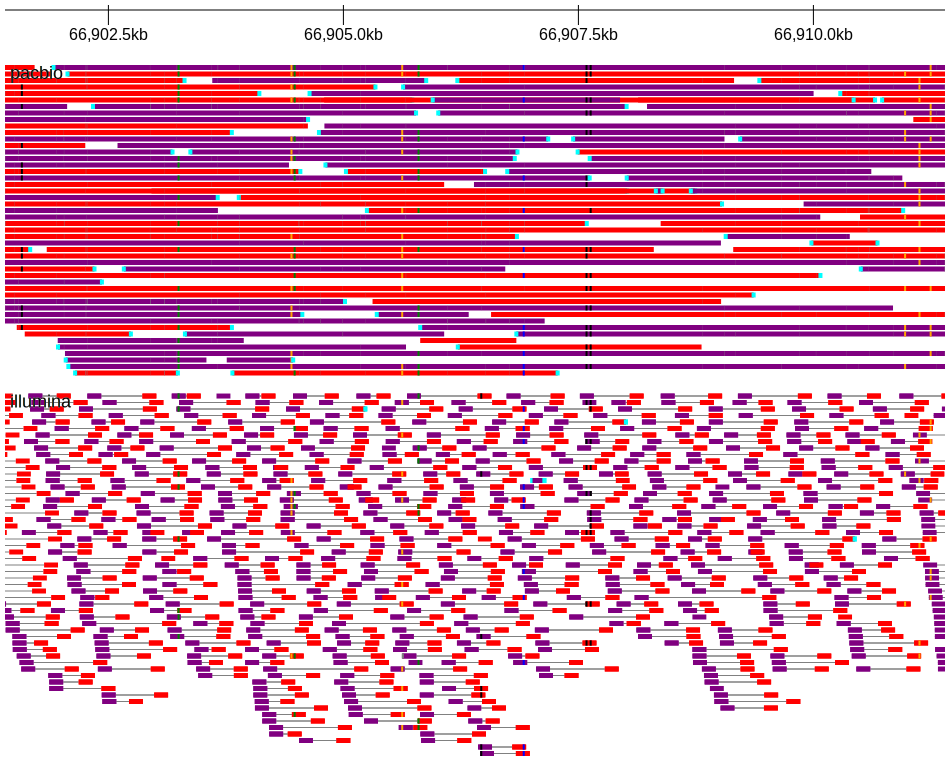

In [4]:
track_info = [("pacbio", "data/pacbio.chr14.bam", "single"),
              ("illumina", "data/illumina.chr14.bam", "paired")]
chrom = "14"
start = 66901400
tracks = visualize_tracks(track_info, chrom, start, start+10000, genome_path)

tracks

Let's take advantage of the fact that we're doing all the drawing in python, and use a custom function to determine the color of the read pairs.

<function color_by_strand at 0x2ba1e5af1950>


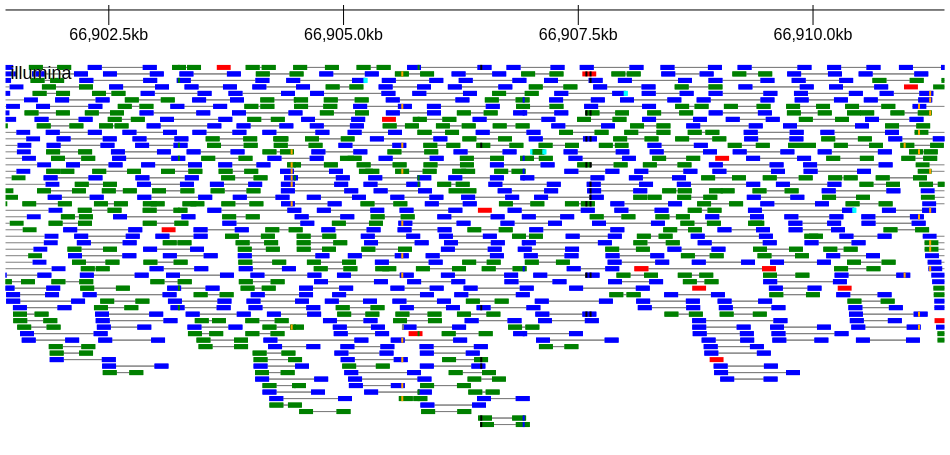

In [5]:
def color_by_insert_size(interval):
    if abs(interval.read.isize) < 100 or abs(interval.read.isize) > 1500:
        return "red"
    if abs(interval.read.isize) > 550:
        return "blue"
    return "green"

doc = genomeview.Document(950)
source = genomesource.FastaGenomeSource(genome_path)

gv = get_genome_view(track_info[1:2], chrom, start, start+10000, source)
print(list(gv.tracks.values())[1].color_fn)
list(gv.tracks.values())[1].color_fn = color_by_insert_size 
doc.elements.append(gv)

doc

**performance is reasonably fast** - note that the pacbio "quick consensus" viewing takes the bulk of the time

In [6]:
%timeit svg = "\n".join(tracks.render())

1.88 s ± 42.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Modular design
Components can be grouped together, not only vertically (as above) but also horizontally, as demonstrated below.

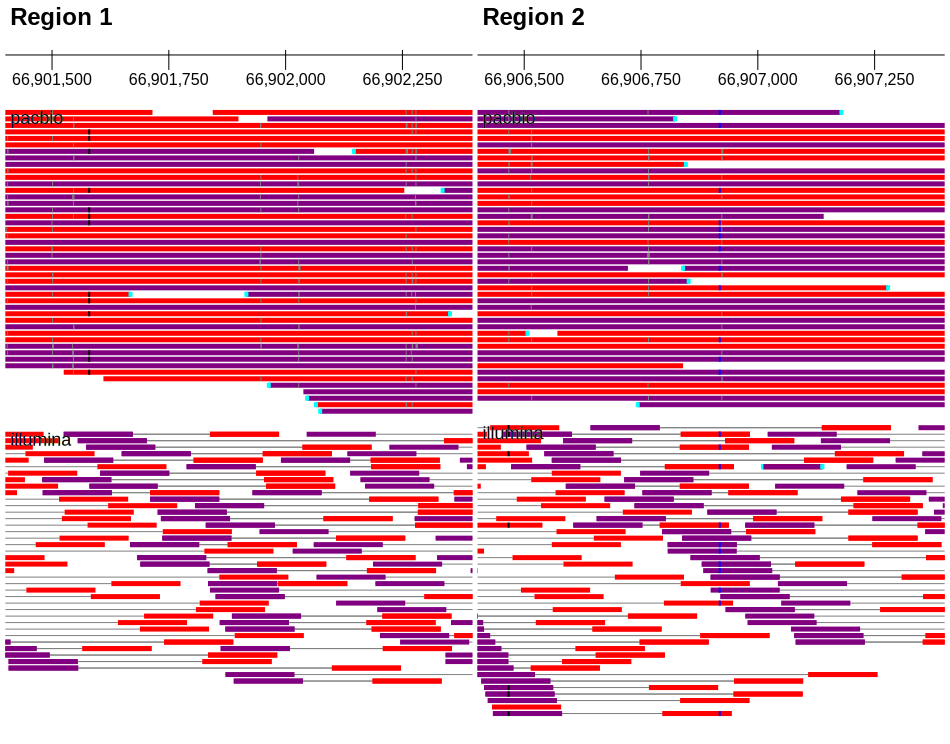

In [6]:
doc = genomeview.Document(950)
source = genomesource.FastaGenomeSource(genome_path)

row = genomeview.ViewRow("row")

for i, cur_start in enumerate([start, start+5000]):
    gv = get_genome_view(track_info, "14", cur_start, cur_start+1000, source)
    gv.name = "view_" + str(cur_start)
    
    # Add a text label
    label_track = genomeview.track.TrackLabel("Region {}".format(i+1))
    gv.add_track(label_track)
    gv.tracks.move_to_end(label_track.name, last=False) # move it to the beginning, to show at top
    
    # Add the genome view to the end of the row
    row.add_view(gv)
    
doc.elements.append(row)
doc

## Custom drawing callbacks

Pre-renderers and post-renderers are code that get run before and after (respectively) drawing the track. This allows compositing additional visual elements such as highlighting a genomic region or adding text, without creating a custom Track subclass.

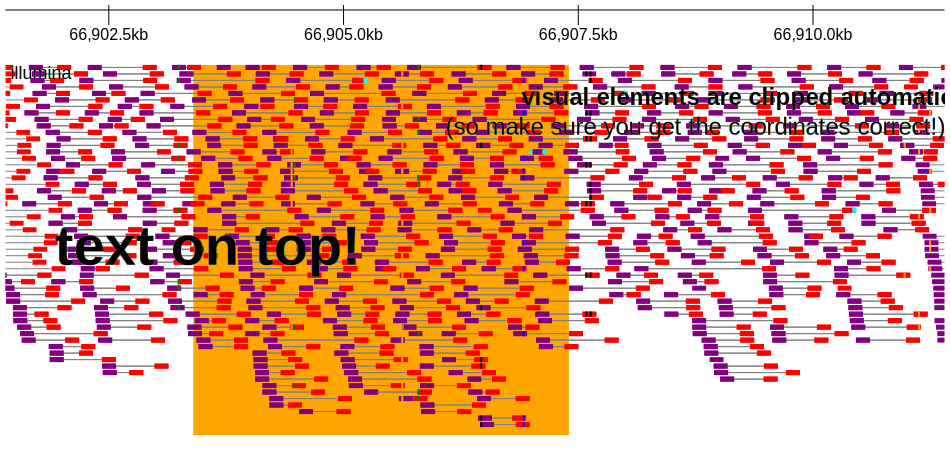

In [8]:
def prerender(renderer, element):
    # prerenderers get run before the track is rendered
    x1 = element.scale.topixels(start+2000) # converting genomic coordinates to screen coordinates
    x2 = element.scale.topixels(start+6000)
    yield from renderer.rect(x1, 0, x2-x1, element.height, fill="orange", stroke="none")
    
def postrender(renderer, element):
    # we'll render this with screen coordinates (not genomic coordinates)
    yield from renderer.text_with_background(200, 200, "text on top!", size=56, bg_opacity=1.0, **{"font-weight":"bold"})
    
    width = element.scale.pixel_width
    yield from renderer.text_with_background(width+50, 40, "visual elements are clipped automatically", size=24, bg_opacity=1.0, anchor="end", **{"font-weight":"bold"})
    yield from renderer.text_with_background(width, 70, "(so make sure you get the coordinates correct!)", size=24, bg_opacity=1.0, anchor="end")



doc = genomeview.Document(950)
source = genomesource.FastaGenomeSource(genome_path)

gv = get_genome_view(track_info[1:2], chrom, start, start+10000, source)
cur_track = list(gv.tracks.values())[1]
cur_track.prerenderers = [prerender]
cur_track.postrenderers = [postrender]
doc.elements.append(gv)

doc

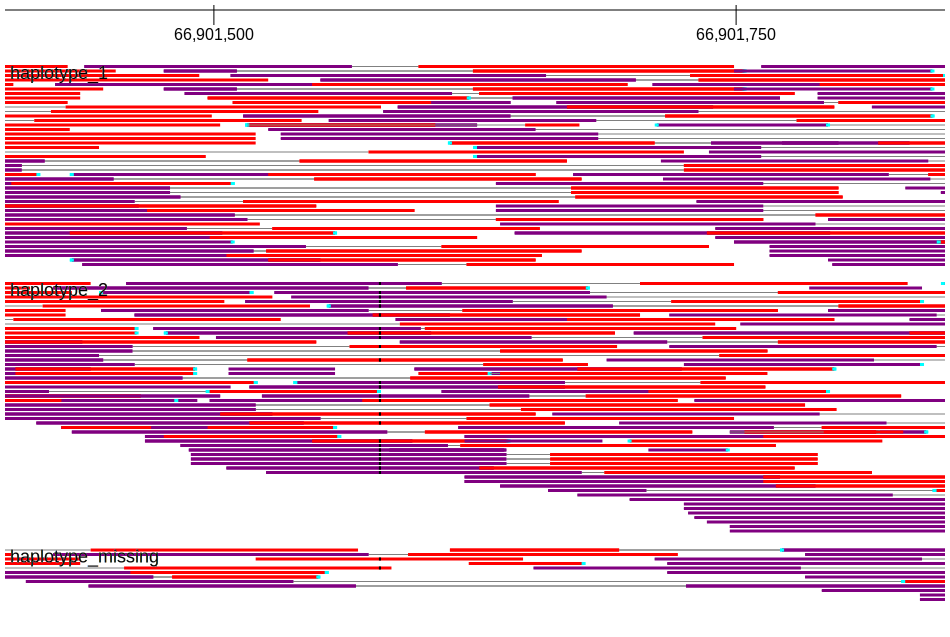

In [5]:
import pysam
import genomeview.track
from genomeview.utilities import match_chrom_format

class MyPairedEndBAMTrack(PairedEndBAMTrack):
    def __init__(self, *args, **kwdargs):
        super().__init__(*args, **kwdargs)
        self.row_height = 3
        self.margin_y = 1.5
        
doc = genomeview.Document(950)
source = genomesource.FastaGenomeSource(genome_path)

gv = genomeview.genomeview.GenomeView("bam", chrom, start, start+450, "+", source)

# Add the coordinate axis at the top
axis = genomeview.axis.Axis("axis")
gv.add_track(axis)

bam_track = genomeview.bamtrack.GroupedBAMTrack("grouped", "data/10x.chr14.bam", 
                                                genomeview.bamtrack.get_group_by_tag_fn("HP"),
                                                MyPairedEndBAMTrack)
bam_track.category_label_fn = lambda x: "haplotype_{}".format(x)
gv.add_track(bam_track)

doc.elements.append(gv)

doc